---
<center><h1>Configuration & Imports</h1></center>

In [31]:
import os
# DECLARE HOW MANY GPUS YOU WISH TO USE. 
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

# VERSION FOR SAVING/LOADING MODEL WEIGHTS
# THIS SHOULD MATCH THE MODEL IN LOAD_MODEL_FROM

VER=1 

# IF VARIABLE IS NONE, THEN NOTEBOOK COMPUTES TOKENS
# OTHERWISE NOTEBOOK LOADS TOKENS FROM PATH
# LOAD_TOKENS_FROM = '../input/tf-longformer-v12'
LOAD_TOKENS_FROM = None

# IF VARIABLE IS NONE, THEN NOTEBOOK TRAINS A NEW MODEL
# OTHERWISE IT LOADS YOUR PREVIOUSLY TRAINED MODEL
# LOAD_MODEL_FROM = '../input/tflongformerv14'
LOAD_MODEL_FROM = None

# IF FOLLOWING IS NONE, THEN NOTEBOOK 
# USES INTERNET AND DOWNLOADS HUGGINGFACE 
# CONFIG, TOKENIZER, AND MODEL
# DOWNLOADED_MODEL_PATH = '../input/tf-longformer-v12'
DOWNLOADED_MODEL_PATH = None

if DOWNLOADED_MODEL_PATH is None:
    DOWNLOADED_MODEL_PATH = 'model'    
MODEL_NAME = 'allenai/longformer-base-4096'

INPUT_PATH = 'C:/Users/Vinay/Documents/CS5934_Annotation_Dataset/'
CSV_FILE = "train.csv"
TRAIN_CSV_PATH = INPUT_PATH + CSV_FILE
TRAIN_PATH = INPUT_PATH + 'train/'
TEST_PATH = INPUT_PATH + 'test/'
MODEL_PATH = 'model'
BAR = '--------------------------------------------------------------'

<h3>Import Libraries</h3>

In [32]:
import pandas as pd, numpy as np
import random
from spacy import displacy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from transformers import AutoTokenizer, AutoConfig, TFAutoModel
print('TF version',tf.__version__)
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TF version 2.11.1


<h3>Single or Mirrored Strategy</h3>

In [33]:
# USE MULTIPLE GPUS
if os.environ["CUDA_VISIBLE_DEVICES"].count(',') == 0:
    strategy = tf.distribute.get_strategy()
    print('single strategy')
else:
    strategy = tf.distribute.MirroredStrategy()
    print('multiple strategy')

single strategy


In [34]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

Mixed precision enabled


---
<center><h1> Exploratory Data Analysis </h1></center>

<h3>Read csv file and sample it</h3>

In [35]:
df = pd.read_csv(TRAIN_CSV_PATH)
print("Number of discourse anottations =", df.shape[0])
df.head()

Number of discourse anottations = 144293


id  discourse_id  discourse_start  discourse_end  \
0  423A1CA112E2  1.622628e+12              8.0          229.0   
1  423A1CA112E2  1.622628e+12            230.0          312.0   
2  423A1CA112E2  1.622628e+12            313.0          401.0   
3  423A1CA112E2  1.622628e+12            402.0          758.0   
4  423A1CA112E2  1.622628e+12            759.0          886.0   

                                      discourse_text discourse_type  \
0  Modern humans today are always on their phone....           Lead   
1  They are some really bad consequences when stu...       Position   
2  Some certain areas in the United States ban ph...       Evidence   
3  When people have phones, they know about certa...       Evidence   
4  Driving is one of the way how to get around. P...          Claim   

  discourse_type_num                                   predictionstring  
0             Lead 1  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...  
1         Position 1       45 46 47 48 49 50 51 52 53 54 55 56 57 58 59  
2         Evidence 1    60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75  
3         Evidence 2  76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...  
4            Claim 1  139 140 141 142 143 144 145 146 147 148 149 15...

<h3>Summary of column info & type</h3>

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144293 entries, 0 to 144292
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  144293 non-null  object 
 1   discourse_id        144293 non-null  float64
 2   discourse_start     144293 non-null  float64
 3   discourse_end       144293 non-null  float64
 4   discourse_text      144293 non-null  object 
 5   discourse_type      144293 non-null  object 
 6   discourse_type_num  144293 non-null  object 
 7   predictionstring    144293 non-null  object 
dtypes: float64(3), object(5)
memory usage: 8.8+ MB


<h3>Presense of NaNs:</h3>

In [37]:
df.isnull().sum()

id                    0
discourse_id          0
discourse_start       0
discourse_end         0
discourse_text        0
discourse_type        0
discourse_type_num    0
predictionstring      0
dtype: int64

train.csv contains no nulls.

<h3>Number of articles</h3>
How many articles are mentioned in the train.csv?

In [38]:
id_list, num_articles = df['id'].unique(),df['id'].nunique()
print(f"There are {num_articles} unique articles in train.csv.")

There are 15594 unique articles in train.csv.


Verify number of unique articles is the same as actual article text files:

In [39]:
# all text files
txt_list = os.listdir(TRAIN_PATH)
txt_list_stripped = [l[:-4] for l in txt_list] # strip .txt 
ids = list(df['id'])
# Verify text files match to csv
try:
    assert(set(txt_list_stripped)==set(ids))
    print(f"Number of unique articles is the same as actual article text files")
except AssertionError:
    print(f"Number of unique articles is --NOT-- the same as actual article text files")

Number of unique articles is the same as actual article text files


<h3> Unique discourse types </h3>
All unique discourse types:

In [40]:
discourse_types = list(df['discourse_type'].unique())
print(discourse_types)
num_unique_discourse = len(discourse_types)

['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement', 'Counterclaim', 'Rebuttal']


<h3> Visualize several articles with displacy </h3>
let's visualize several articles with the appropriate discourse annotations:

In [41]:
color_dict = {
            'Lead': '#f39b79',
            'Position': '#2f8ceb',
            'Evidence': '#00ff95',
            'Claim': '#962fbf',
            'Rebuttal': '#ff0000',
            'Counterclaim': '#fff59b',
            'Concluding Statement': '#fa7e1e'        
         }

def construct_entities(df, chosen_id):
    """ Constructs entity list for the specified article ID"""
    
    ents = []
    for index,row in df.query("id == @chosen_id").iterrows():
        ents.append({
                'start': int(row['discourse_start']), 
                'end': int(row['discourse_end']), 
                'label': row['discourse_type']
                    })
    return ents

def visualize(chosen_id):
    """Displays discourses for specified article ID"""
    
    ents = construct_entities(df, chosen_id)
    with open(TRAIN_PATH + chosen_id + '.txt', 'r') as file: 
        data = file.read()

    doc = {
        "text": data,
        "ents": ents,
        "title": chosen_id
    }

    options = {"ents": discourse_types, "colors": color_dict}
    displacy.render(doc, style="ent", options=options, manual=True, jupyter=True)

In [42]:
random_articles = random.choices(ids, k=3)
for article in random_articles:
    visualize(article)
    print(BAR)

--------------------------------------------------------------


--------------------------------------------------------------


--------------------------------------------------------------


Some insights from visual inspection:
- There are words not belonging to any of the discourse types.
- A discourse could start in the middle of the sentence, so punctuation isn't always a delimiter.
- Not all articles have all the discourse types.

<h3>Distribution of number of  discourse types per article</h3>

In [43]:
def annotate(splot, total_size, precision, percentage='on'):
  """Helper function to annotate graphs"""
  k = {'on':100/total_size, 'off': 1}
  for p in splot.patches:
    splot.annotate(format(k[percentage]*p.get_height(),f'.{precision}f') + '%',
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 10),
                  textcoords = 'offset points')

In [44]:
sns.set(style="darkgrid", context="talk",rc={'figure.figsize':(11.7,8.27)})
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})

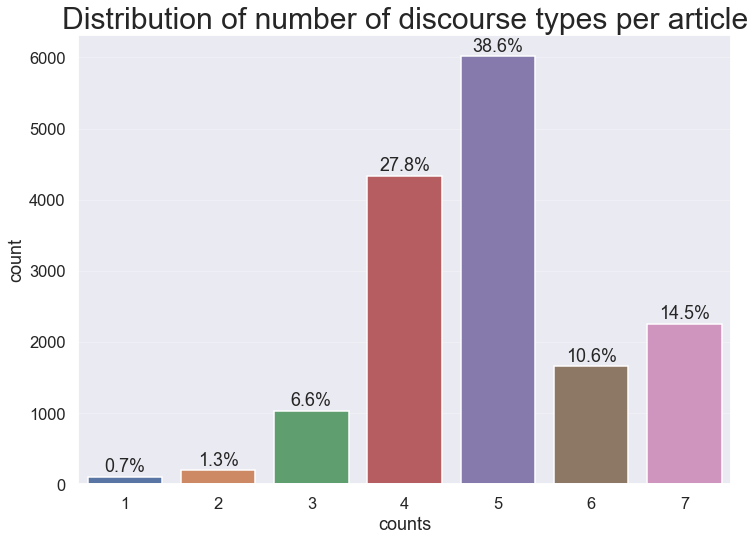

In [45]:
df_eda = df[['id','discourse_type']].drop_duplicates().groupby(by='id').size().reset_index(name='counts')
splot = sns.countplot(x='counts', data=df_eda)
annotate(splot, df_eda.shape[0], 1, percentage='on')
plt.title('Distribution of number of discourse types per article', fontsize=30);

We see that only 14.5% of all articles have all of the discourse types.  
About 2/3 of the articles have 4 or 5 discourse types.

<h3>Discource type present at least once in article distribution</h3>  
<h3>Discource type count distribution per article</h3>

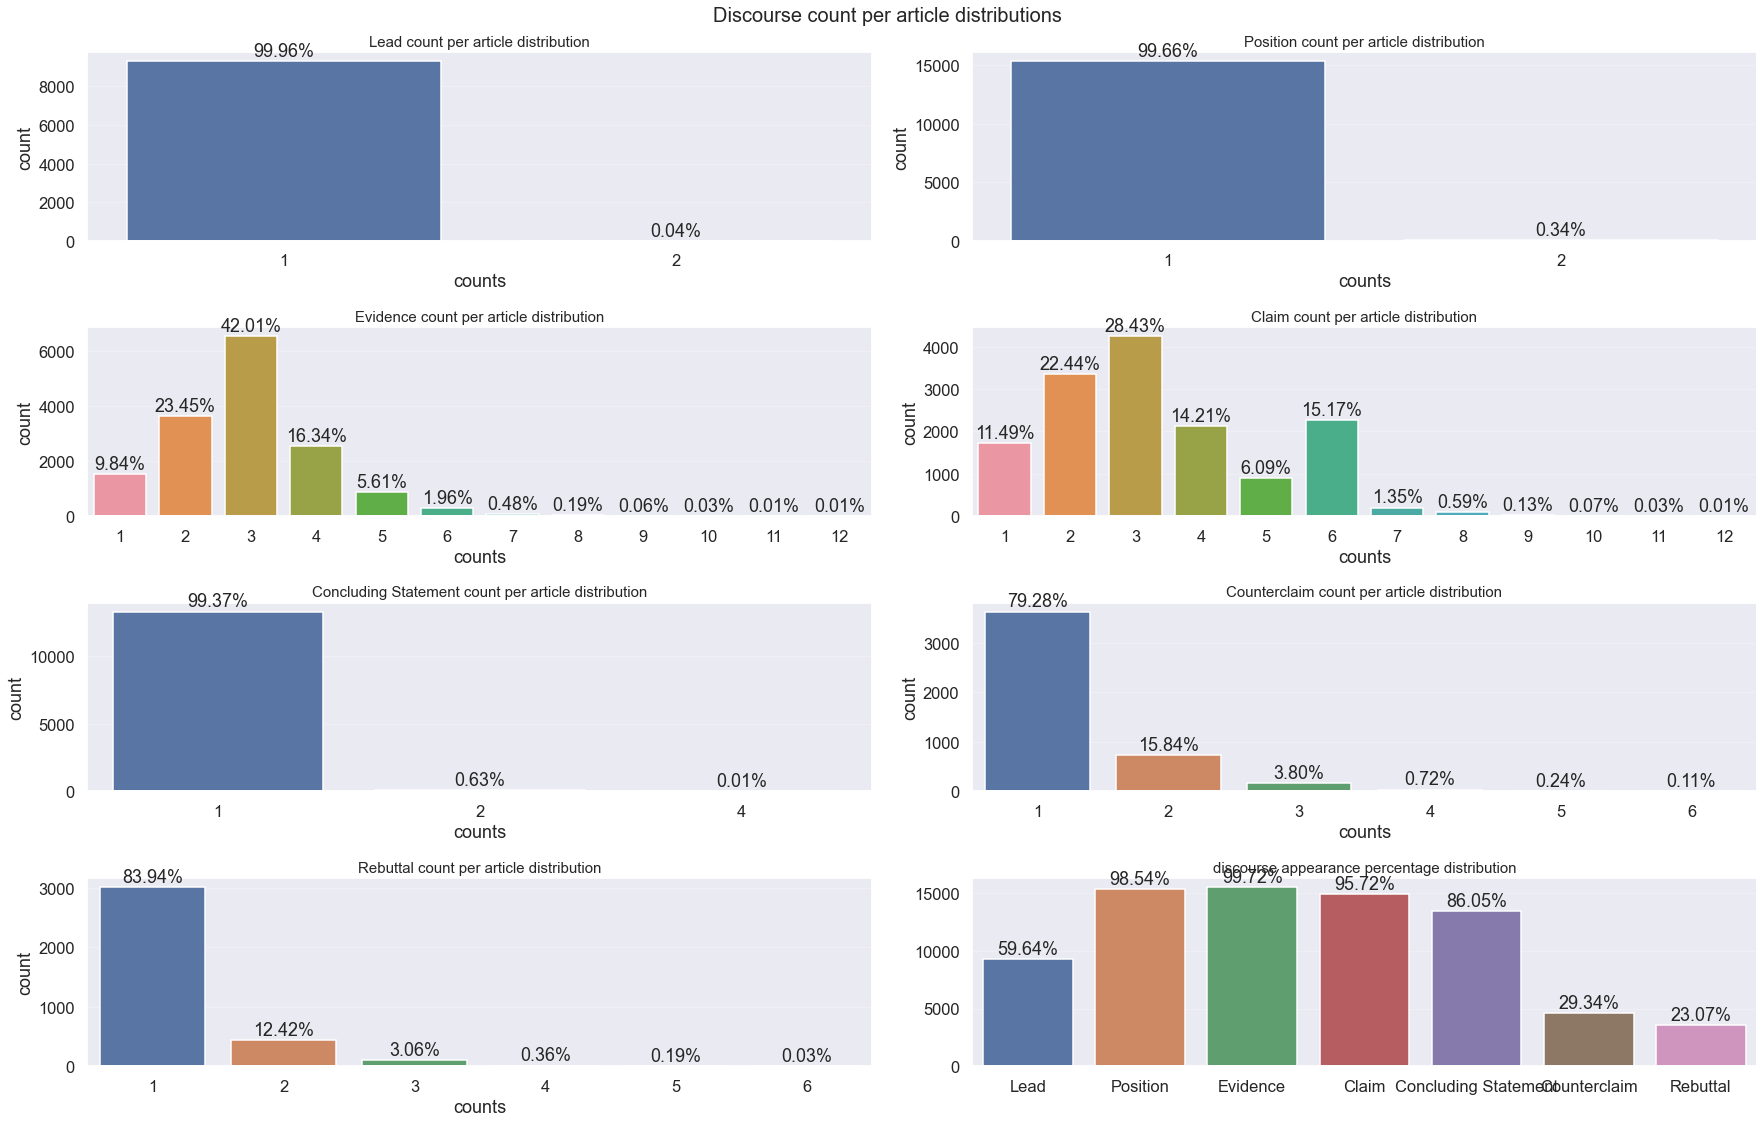

In [46]:
df_eda = df[['id','discourse_type']].groupby(by=['id','discourse_type']).size().reset_index(name='counts')
discourse_types = list(df['discourse_type'].unique())

lst = []

fig, ax = plt.subplots(4,2, figsize=(25,16))
fig.suptitle('Discourse count per article distributions',fontsize=20)
for index in range(len(discourse_types)):
  i,j = index //2, index %2
  dis_type = discourse_types[index]
  df_a = df_eda[df_eda['discourse_type'] == dis_type]
  lst.append(df_a.shape[0])
  splot = sns.countplot(ax=ax[i,j],x='counts', data=df_a)
  ax[i,j].set_title(f"{dis_type} count per article distribution",fontsize=15)
  annotate(splot, df_a.shape[0],2, percentage='on')
fig.tight_layout()
fig.subplots_adjust(top=0.94);

splot = sns.barplot(x=discourse_types, y=lst)
annotate(splot, num_articles,2, percentage='on')
plt.title('discourse appearance percentage distribution', fontsize=15);

We notice from the last graph:  
1. Position, claim and Evidence appear in more than 95% of the articles.
2. Most of the articles don't have rebuttal or claim , thus most of the articles are "one-sided".

From the rest of the graphs we conclude:
1. Lead, Position, Concluding statement in almost all cases appear once. This suggets that vast majority of the articles deal with one topic.
2. We also notice that claim and evidence have a more diverse distribution, with median = 3 per article:

<h3>Text Length Distribution of Texts Filtered by the Discourses</h3>

In [47]:
df_a = df['discourse_text'].groupby(df['id']).transform(lambda x: ' '.join(x)).drop_duplicates().str.len()

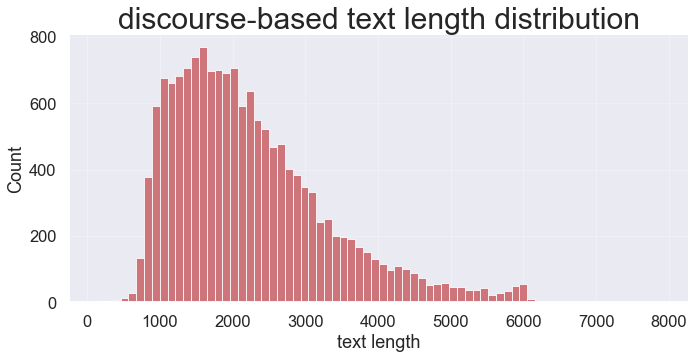

In [48]:
sns.displot(df_a,color='r', aspect=2)
plt.title("discourse-based text length distribution", fontsize=30)
plt.xlabel('text length')
plt.show()

<h3>Discourse length distribution per each discourse type</h3>

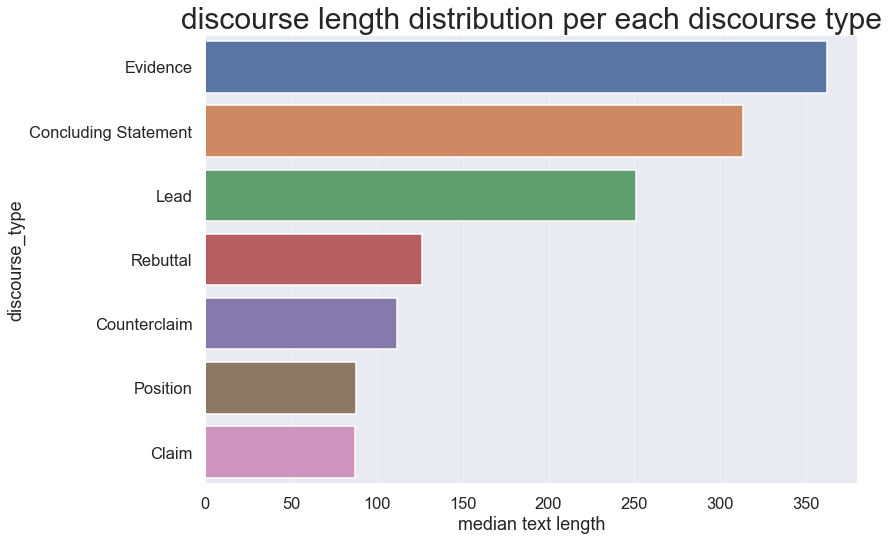

In [49]:
df['discourse_length'] = df['discourse_text'].str.len()
df_a = df.groupby('discourse_type')['discourse_length'].median().sort_values(ascending=False)
splot = sns.barplot(y=df_a.index, x=df_a.values)
plt.title('discourse length distribution per each discourse type', fontsize=30)
plt.xlabel('median text length')
plt.show()

We notice that evidence is the dominant discourse from text length prespective, while claim & position are the shortest.

<h3>Discourse Position Tendency</h3>

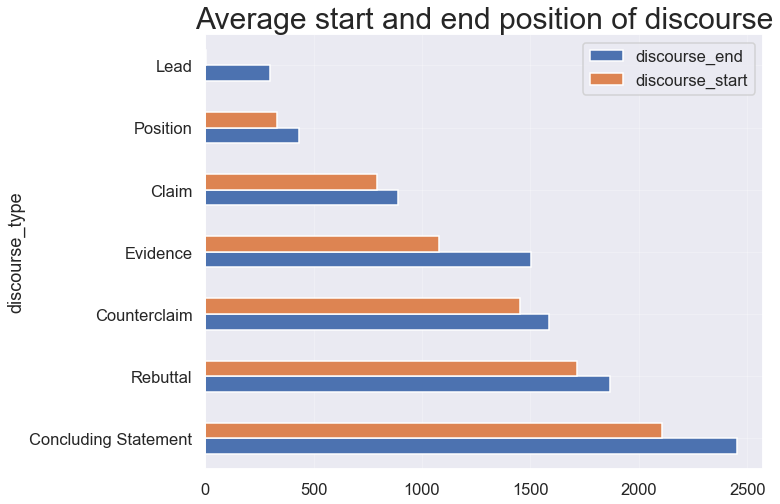

In [50]:
df_a = df.groupby("discourse_type")[['discourse_end', 'discourse_start']].mean().reset_index().sort_values(
    by = 'discourse_start', 
    ascending = False)
df_a.plot(x='discourse_type',
        kind='barh',
        figsize=(10,8))
plt.title('Average start and end position of discourse',fontsize=30 )
plt.show()

<h3>n-grams analysis</h3>

In [51]:
def get_n_grams(n_grams, top_n = 10):
    
    df_words = pd.DataFrame()
    
    for dt in discourse_types:
        
        df_a = df[df['discourse_type']==dt]
        texts = df_a['discourse_text'].tolist()
        vec = CountVectorizer(lowercase = True, stop_words = 'english',\
                              ngram_range=(n_grams, n_grams)).fit(texts)
        bag_of_words = vec.transform(texts)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        cvec_df = pd.DataFrame.from_records(words_freq,\
                                            columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
        cvec_df.insert(0, "Discourse_type", dt)
        cvec_df = cvec_df.iloc[:top_n,:]
        df_words = df_words.append(cvec_df)
        
    return df_words

def plot_ngram(df, type = "unigrams"):
    
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)

    for n, dt in enumerate(df.Discourse_type.unique()):
        ax = plt.subplot(4, 2, n + 1)
        ax.set_title(f"Most frequent {type} in {dt}")
        data = df.query('Discourse_type == @dt')[['words', 'counts']].set_index("words").sort_values(by = "counts", ascending = True)
        data.plot(ax=ax, kind = 'barh', color = 'steelblue', legend=False)
        plt.ylabel("")
    plt.tight_layout()
    plt.show()

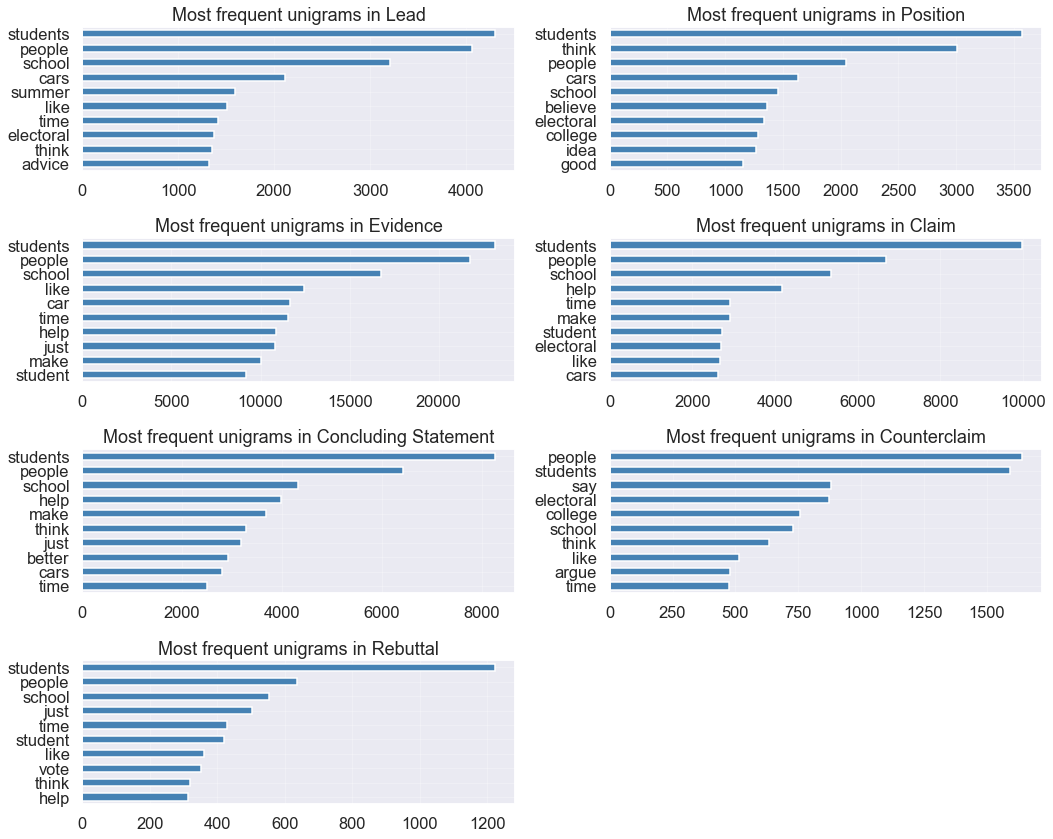

In [52]:
unigrams = get_n_grams(n_grams = 1, top_n=10)
plot_ngram(unigrams)

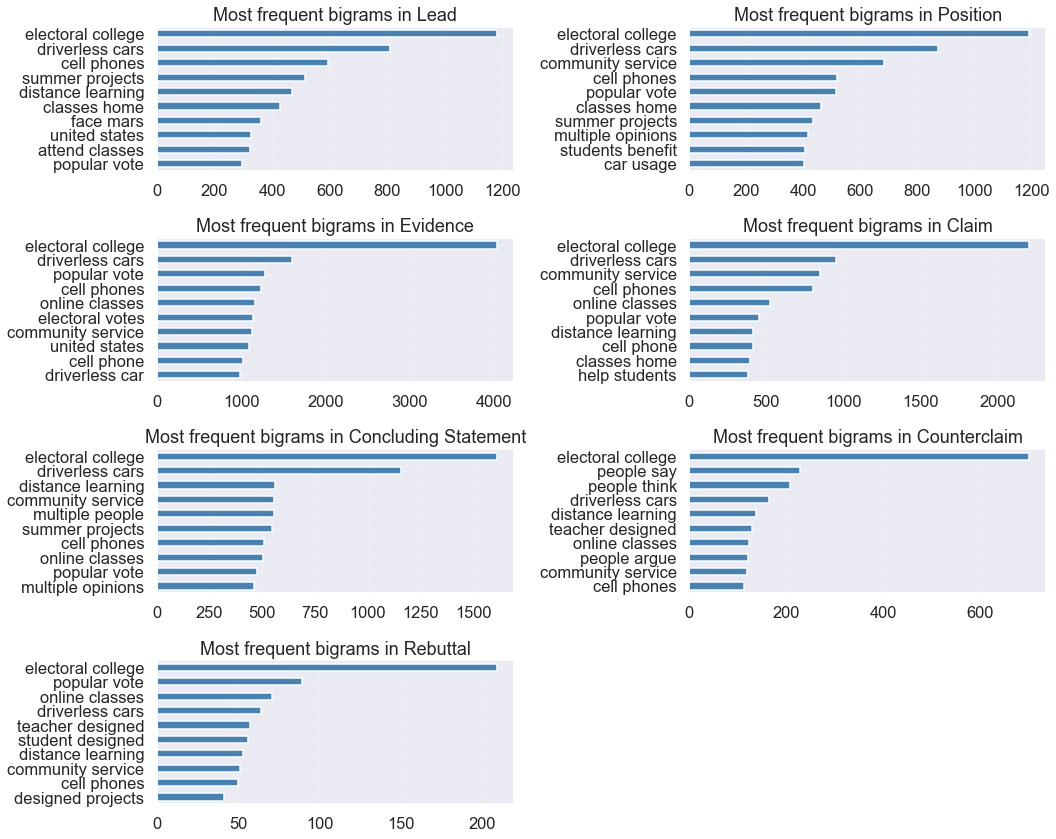

In [53]:
bigrams = get_n_grams(n_grams = 2, top_n=10)
plot_ngram(bigrams,type='bigrams')

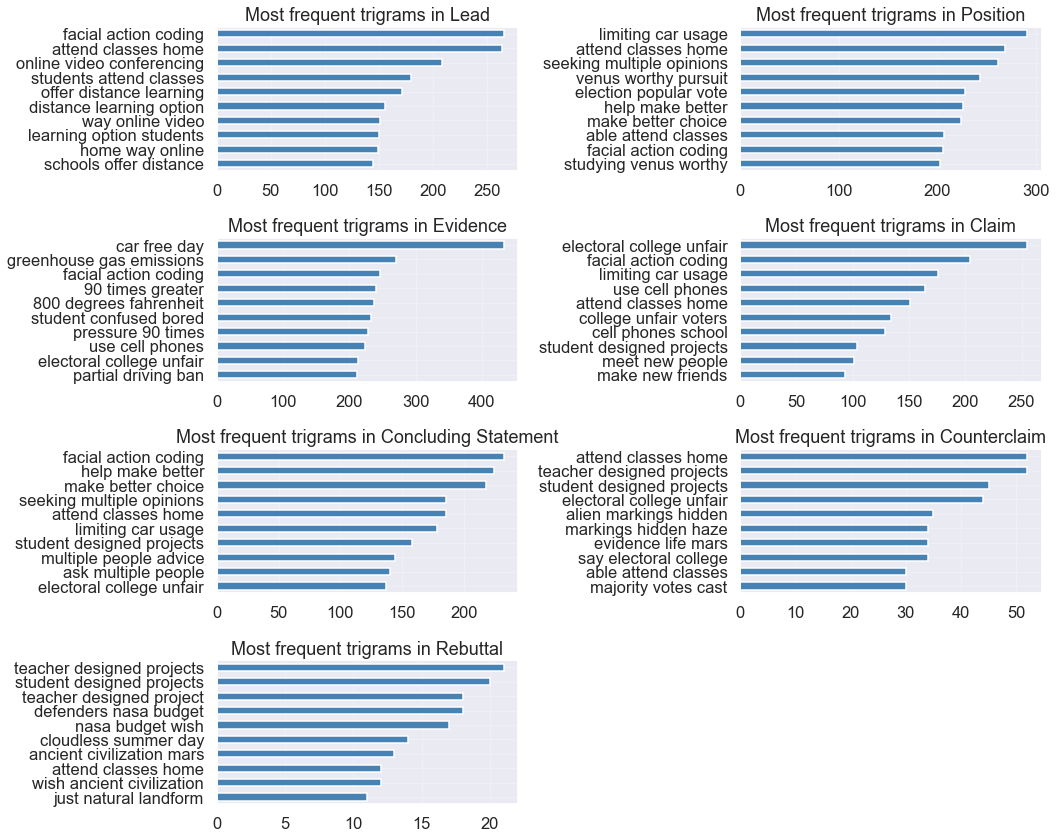

In [54]:
trigrams = get_n_grams(n_grams = 3, top_n=10)
plot_ngram(trigrams, 'trigrams')

We notice the following:
1. The most popular unigrams are students, school and people in most of the discourses 
2. The most popular bigrams are electoral college, driverless cars in most of the discourses
3. trigrams are more diverse, they don't have a clear common most popular trigram in most of the discourses. 


---